# Data Analysis

(See the Results section for results)

In [1]:
import pandas as pd
from datetime import datetime

### Helper methods

In [2]:
def select_time_frame(metrics_data_df: pd.DataFrame, from_time: datetime, to_time: datetime, freq15s=True):
    try:
        metrics_data_df.date = metrics_data_df.date.apply(lambda datetime_str: datetime.strptime(datetime_str, '%m/%d/%Y %I:%M:%S.000000000 %p'))
    except:
        pass
    if freq15s:
        return groupby_15s(metrics_data_df[(metrics_data_df.date > from_time) & (metrics_data_df.date < to_time)], metrics_data_df.columns[-1])
    return metrics_data_df[(metrics_data_df.date > from_time) & (metrics_data_df.date < to_time)]


def select_pod_proxy_application_metrics(metrics_data_df: pd.DataFrame, pods: bool, proxies: bool, applications: bool, deucalion_sidecars: bool):
    if (pods or proxies or applications or deucalion_sidecars):
        match_strings = []
        if proxies: 
            match_strings.append('(k8s_istio-proxy)')
        if pods:
            match_strings.append('(k8s_POD)')
        if applications:
            match_strings.append('(k8s_(((?!(POD)|(istio)|(deucalion)).)))')
        if deucalion_sidecars:
            match_strings.append('(k8s_deucalion)')
        match_string = '|'.join(match_strings)
        return metrics_data_df[metrics_data_df.container_name.str.match(match_string)]
    else:
        raise Exception('no container types specified')

def print_overhead_summary(dfs, metrics_str: str, index, columns, pods: bool, proxies: bool, applications: bool, deucalion_sidecars: bool):
    data = []
    for df in dfs:
        data.append([select_pod_proxy_application_metrics(df, pods, proxies, applications, deucalion_sidecars)[metrics_str].sum() / ((df.date.iloc[-1] - df.date.iloc[0]).total_seconds()), select_pod_proxy_application_metrics(df, pods, proxies, applications, deucalion_sidecars)[metrics_str].std() / 15])
    overhead_df = pd.DataFrame(data, index, columns)
    overhead_df['pct_overhead_baseline'] = overhead_df[columns[0]].apply(lambda x: (x/overhead_df[columns[0]][[0]][0] - 1) * 100)
    display(overhead_df)
    return overhead_df

def groupby_15s(df, metrics_name):
    res = pd.DataFrame(columns=['container_name', 'date', metrics_name])
    foo = df.groupby(['container_name', pd.Grouper(key='date', freq='15s')]).sum()
    indexes = foo.index
    for index in indexes:
        res = pd.concat([res, pd.DataFrame([[index[0], index[1], foo[metrics_name][index]]], columns=['container_name', 'date', metrics_name])])
        
    return res.reset_index(drop=True)





### Read in metricsdata from data/metrics_data directory

In [3]:
# Without monitoring
without_monitoring_tx_bytes = pd.read_csv('data/metrics_data/without_monitoring/pods_tx_bytes.csv')
without_monitoring_rx_bytes = pd.read_csv('data/metrics_data/without_monitoring/details-pod-rx.csv')
without_monitoring_cpu = pd.read_csv('data/metrics_data/without_monitoring/details-cpu.csv')
without_monitoring_mem = pd.read_csv('data/metrics_data/without_monitoring/details-memory.csv')

# With prometheus monitoring
with_prometheus_monitoring_tx_bytes = pd.read_csv('data/metrics_data/standard_prometheus/pods_tx_bytes.csv')
with_prometheus_monitoring_rx_bytes = pd.read_csv('data/metrics_data/standard_prometheus/details-pod-rx.csv')
with_prometheus_monitoring_cpu = pd.read_csv('data/metrics_data/standard_prometheus/details-cpu.csv')
with_prometheus_monitoring_mem = pd.read_csv('data/metrics_data/standard_prometheus/details-memory.csv')

# Sidecar
sidecar_tx_bytes = pd.read_csv('data/metrics_data/sidecar/pods_tx_bytes.csv')
sidecar_rx_bytes = pd.read_csv('data/metrics_data/sidecar/details-pod-rx.csv')
sidecar_cpu = pd.read_csv('data/metrics_data/sidecar/details-cpu.csv')
sidecar_mem = pd.read_csv('data/metrics_data/sidecar/details-memory.csv')

# Federated
federated_tx_bytes = pd.read_csv('data/metrics_data/federated/pods_tx_bytes.csv')
federated_rx_bytes = pd.read_csv('data/metrics_data/federated/details-pod-rx.csv')
federated_tx_bytes_prometheus = pd.read_csv('data/metrics_data/federated/pods_tx_bytes_prometheus.csv')
federated_rx_bytes_prometheus = pd.read_csv('data/metrics_data/federated/details-pod-rx_prometheus.csv')
federated_cpu = pd.read_csv('data/metrics_data/federated/details-cpu.csv')
federated_cpu_prometheus = pd.read_csv('data/metrics_data/federated/details-cpu_prometheus.csv')
federated_mem = pd.read_csv('data/metrics_data/federated/details-memory.csv')
federated_mem_prometheus = pd.read_csv('data/metrics_data/federated/details-memory_prometheus.csv')

### Select data on the based on timestamp
The raw data contains both the data when the system is at rest, and the data from the load tests. Therefore, the timestamps are used to limit the data to the periods when the system is at rest. 

In [4]:
# Without monitoring
at_rest_start = datetime(2022, 5, 11, 19, 0)
at_rest_stop = datetime(2022, 5, 11, 20, 0)
without_monitoring_tx_bytes_at_rest = select_time_frame(without_monitoring_tx_bytes, at_rest_start, at_rest_stop)
without_monitoring_rx_bytes_at_rest = select_time_frame(without_monitoring_rx_bytes, at_rest_start, at_rest_stop)
without_monitoring_cpu_at_rest = select_time_frame(without_monitoring_cpu, at_rest_start, at_rest_stop)
without_monitoring_mem_at_rest = select_time_frame(without_monitoring_mem, at_rest_start, at_rest_stop)

# With prometheus monitoring
at_rest_start = datetime(2022, 5, 19, 18, 40)
at_rest_stop = datetime(2022, 5, 19, 19, 55)
with_prometheus_monitoring_tx_bytes_at_rest = select_time_frame(with_prometheus_monitoring_tx_bytes, at_rest_start, at_rest_stop)
with_prometheus_monitoring_rx_bytes_at_rest = select_time_frame(with_prometheus_monitoring_rx_bytes, at_rest_start, at_rest_stop)
with_prometheus_monitoring_cpu_at_rest = select_time_frame(with_prometheus_monitoring_cpu, at_rest_start, at_rest_stop)
with_prometheus_monitoring_mem_at_rest = select_time_frame(with_prometheus_monitoring_mem, at_rest_start, at_rest_stop)

# Sidecar
at_rest_start = datetime(2022, 5, 15, 16, 0)
at_rest_stop = datetime(2022, 5, 15, 19, 0)
sidecar_tx_bytes_at_rest = select_time_frame(sidecar_tx_bytes, at_rest_start, at_rest_stop)
sidecar_rx_bytes_at_rest = select_time_frame(sidecar_rx_bytes, at_rest_start, at_rest_stop)
sidecar_cpu_at_rest = select_time_frame(sidecar_cpu, at_rest_start, at_rest_stop)
sidecar_mem_at_rest = select_time_frame(sidecar_mem, at_rest_start, at_rest_stop)

# Federated
at_rest_start = datetime(2022, 5, 12, 22, 20)
at_rest_stop = datetime(2022, 5, 12, 22, 55)
federated_tx_bytes_at_rest = select_time_frame(federated_tx_bytes, at_rest_start, at_rest_stop)
federated_rx_bytes_at_rest =  select_time_frame(federated_rx_bytes, at_rest_start, at_rest_stop)
federated_tx_bytes_prometheus_at_rest =  select_time_frame(federated_tx_bytes_prometheus, at_rest_start, at_rest_stop)
federated_rx_bytes_prometheus_at_rest =  select_time_frame(federated_rx_bytes_prometheus, at_rest_start, at_rest_stop)
federated_cpu_at_rest =  select_time_frame(federated_cpu, at_rest_start, at_rest_stop)
federated_cpu_prometheus_at_rest =  select_time_frame(federated_cpu_prometheus, at_rest_start, at_rest_stop)
federated_mem_at_rest =  select_time_frame(federated_mem, at_rest_start, at_rest_stop)
federated_mem_prometheus_at_rest =  select_time_frame(federated_mem_prometheus, at_rest_start, at_rest_stop)

### Differentiate between metrics of pods, proxies, applications, or sidecars

In [5]:
# Without monitoring
without_monitoring_cpu_at_rest_proxies = select_pod_proxy_application_metrics(without_monitoring_cpu_at_rest, False, True, False, False)
without_monitoring_cpu_at_rest_apps = select_pod_proxy_application_metrics(without_monitoring_cpu_at_rest, False, False, True, False)

without_monitoring_mem_at_rest_proxies = select_pod_proxy_application_metrics(without_monitoring_mem_at_rest, False, True, False, False)
without_monitoring_mem_at_rest_apps = select_pod_proxy_application_metrics(without_monitoring_mem_at_rest, False, False, True, False)

# With prometheus monitoring
with_prometheus_monitoring_cpu_at_rest_proxies = select_pod_proxy_application_metrics(with_prometheus_monitoring_cpu_at_rest, False, True, False, False)
with_prometheus_monitoring_cpu_at_rest_apps = select_pod_proxy_application_metrics(with_prometheus_monitoring_cpu_at_rest, False, False, True, False)

with_prometheus_monitoring_mem_at_rest_proxies = select_pod_proxy_application_metrics(with_prometheus_monitoring_mem_at_rest, False, True, False, False)
with_prometheus_monitoring_mem_at_rest_apps = select_pod_proxy_application_metrics(with_prometheus_monitoring_mem_at_rest, False, False, True, False)

# Sidecar
sidecar_cpu_at_rest_proxies = select_pod_proxy_application_metrics(sidecar_cpu_at_rest, False, True, False, False)
sidecar_cpu_at_rest_apps = select_pod_proxy_application_metrics(sidecar_cpu_at_rest, False, False, True, False)
sidecar_cpu_at_rest_deucalion_sidecars = select_pod_proxy_application_metrics(sidecar_cpu_at_rest, False, False, False, True)

sidecar_mem_at_rest_proxies = select_pod_proxy_application_metrics(sidecar_mem_at_rest, False, True, False, False)
sidecar_mem_at_rest_apps = select_pod_proxy_application_metrics(sidecar_mem_at_rest, False, False, True, False)
sidecar_mem_at_rest_deucalion_sidecars = select_pod_proxy_application_metrics(sidecar_mem_at_rest, False, False, False, True)

# Federated
# not relevant

## Results

### Overhead on transmitted bytes per second for application pods

The cell below shows the number of transmitted bytes per second per pod in a tabular and graphical format. 


,tx_bytes_per_second_mean,tx_bytes_per_second_std,pct_overhead_baseline
Without monitoring,822.342329,97.134771,0.000000
Prometheus,56143.014400,8750.402152,6727.207163
Sidecar architecture,910.577677,113.125722,10.729759
Federated architecture,40709.332134,4647.604268,4850.411853


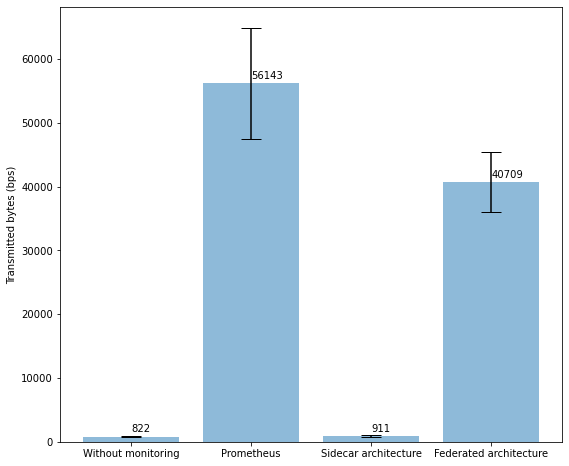

In [6]:
from matplotlib import pyplot as plt
def barplot(df, mean_str, std_str, ylabel, spacing):   
    fig, ax = plt.subplots(figsize=(9,8))
    ax.bar(df.index, mean_str, yerr=std_str, alpha=0.5, data=df, capsize=10)
    for index, row in pd.DataFrame(df[mean_str]).iterrows():
        ax.text(index, row[mean_str] + spacing, round(row[mean_str]), )
    plt.ylabel(ylabel)


tx_overhead_df = print_overhead_summary([without_monitoring_tx_bytes_at_rest, with_prometheus_monitoring_tx_bytes_at_rest, sidecar_tx_bytes_at_rest, federated_tx_bytes_at_rest], 'tx_bytes.mean_value', ['Without monitoring', 'Prometheus', 'Sidecar architecture', 'Federated architecture'], ['tx_bytes_per_second_mean', 'tx_bytes_per_second_std'], True, False, False, False)
barplot(tx_overhead_df, 'tx_bytes_per_second_mean', 'tx_bytes_per_second_std', 'Transmitted bytes (bps)', 700)
plt.savefig('tx_bytes.png')

### Overhead on received bytes per second for application pods

The cell below shows the number of received bytes per second per pod in a tabular and graphical format. 


,rx_bytes_per_second_mean,rx_bytes_per_second_std,pct_overhead_baseline
Without monitoring,1190.320758,375.475735,0.000000
Prometheus,1670.310145,495.927285,40.324373
Sidecar architecture,1314.260604,439.692589,10.412307
Federated architecture,1530.256555,291.351834,28.558336


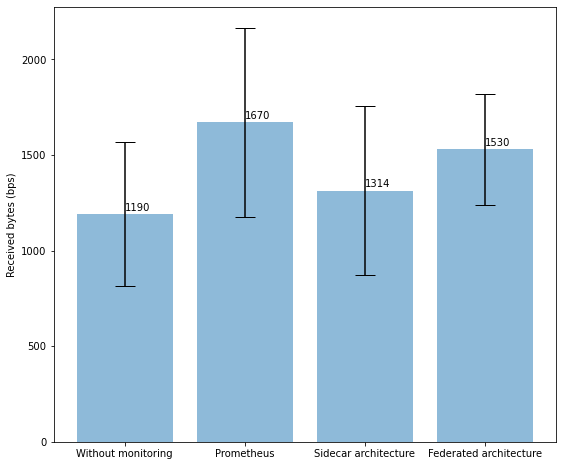

In [7]:
rx_overhead_df = print_overhead_summary([without_monitoring_rx_bytes_at_rest, with_prometheus_monitoring_rx_bytes_at_rest, sidecar_rx_bytes_at_rest, federated_rx_bytes_at_rest], 'rx_bytes.mean_value', ['Without monitoring', 'Prometheus', 'Sidecar architecture', 'Federated architecture'], ['rx_bytes_per_second_mean', 'rx_bytes_per_second_std'], True, False, False, False)
barplot(rx_overhead_df, 'rx_bytes_per_second_mean', 'rx_bytes_per_second_std', 'Received bytes (bps)', 20)
plt.savefig('rx_bytes.png')

### CPU-overhead on proxies

The cell below shows the CPU time consumed by the proxies residing next to an application container, in a tabular and graphical format. 


,cpu_nanoseconds_per_second_mean,cpu_nanoseconds_per_second_std,pct_overhead_baseline
Without monitoring,2.181890e+07,4.670705e+05,0.000000
Prometheus,2.420394e+07,1.210895e+06,10.931084
Sidecar architecture,2.180968e+07,9.501859e+05,-0.042237
Federated architecture,2.376646e+07,9.713155e+05,8.926020


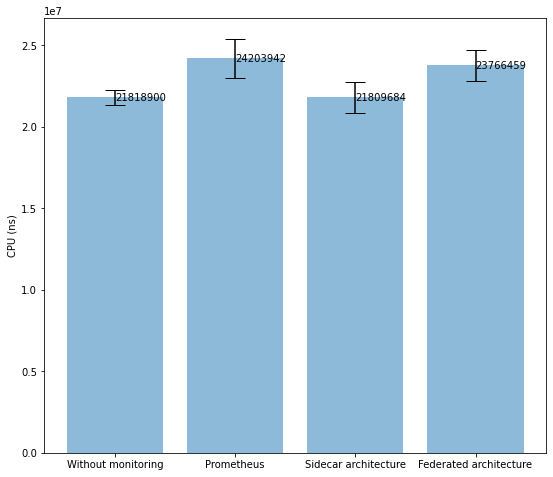

In [8]:
proxy_cpu_overhead_df  = print_overhead_summary([without_monitoring_cpu_at_rest, with_prometheus_monitoring_cpu_at_rest, sidecar_cpu_at_rest, federated_cpu_at_rest], 'cpu_usage_total.mean_value', ['Without monitoring', 'Prometheus', 'Sidecar architecture', 'Federated architecture'], ['cpu_nanoseconds_per_second_mean', 'cpu_nanoseconds_per_second_std'], False, True, False, False)
barplot(proxy_cpu_overhead_df, 'cpu_nanoseconds_per_second_mean', 'cpu_nanoseconds_per_second_std', 'CPU (ns)', -200000)
plt.savefig('cpu_nanoseconds_proxies.png')

### CPU time consumed by Deucalion sidecars, proxies and application containers

,cpu_nanoseconds_per_second_mean,cpu_nanoseconds_per_second_std,pct_overhead_baseline
Deucalion sidecar,3.025467e+06,5.716273e+05,0.000000
Envoy proxy,2.181890e+07,4.670705e+05,621.174550
Application microservices,1.651937e+07,5.163677e+06,446.010678


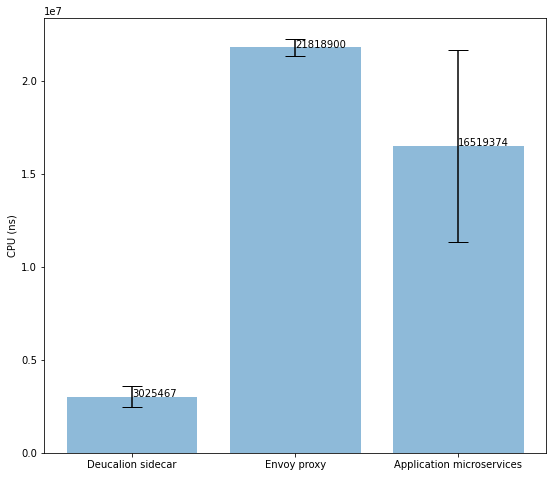

In [9]:
sidecar_overhead_df = print_overhead_summary([sidecar_cpu_at_rest_deucalion_sidecars, without_monitoring_cpu_at_rest_proxies, without_monitoring_cpu_at_rest_apps], 'cpu_usage_total.mean_value', ['Deucalion sidecar', 'Envoy proxy', 'Application microservices'], ['cpu_nanoseconds_per_second_mean', 'cpu_nanoseconds_per_second_std'], False, True, True, True)
barplot(sidecar_overhead_df, 'cpu_nanoseconds_per_second_mean', 'cpu_nanoseconds_per_second_std', 'CPU (ns)', 0)
plt.savefig('cpu_nanoseconds_services.png')

### CPU overhead of using a deucalion sidecar next to a prometheus server (in federated mode)

In [10]:
federated_cpu_prometheus_at_rest = federated_cpu_prometheus_at_rest[federated_cpu_prometheus_at_rest.container_name.str.match('(k8s_deucalion)|(k8s_prometheus-server_)')]
print_overhead_summary([select_pod_proxy_application_metrics(federated_cpu_prometheus_at_rest, False, False, True, False), select_pod_proxy_application_metrics(federated_cpu_prometheus_at_rest, False, False, True, True)], 'cpu_usage_total.mean_value', ['prometheus server', 'with deucalion sidecar'], ['cpu_usage_mean', 'cpu_usage_std'], False, True, True, True)

,cpu_usage_mean,cpu_usage_std,pct_overhead_baseline
prometheus server,8.038641e+06,1.686181e+06,0.0000
with deucalion sidecar,1.049463e+07,1.871442e+06,30.5523


,cpu_usage_mean,cpu_usage_std,pct_overhead_baseline
prometheus server,8.038641e+06,1.686181e+06,0.0000
with deucalion sidecar,1.049463e+07,1.871442e+06,30.5523


### Memory overhead

Some extra helper methods methods are required, because this data cannot be interpreted as a value per second (in contrast to tx/rx-bytes and cpu time). 

In [11]:
# memory helper methods
def groupby_15s_mean(df, metrics_name):
    res = pd.DataFrame(columns=['container_name', 'date', metrics_name])
    foo = df.groupby(['container_name', pd.Grouper(key='date', freq='15s')]).mean()
    indexes = foo.index
    for index in indexes:
        res = pd.concat([res, pd.DataFrame([[index[0], index[1], foo[metrics_name][index]]], columns=['container_name', 'date', metrics_name])])
        
    return res.reset_index(drop=True)

def select_time_frame_mean(metrics_data_df: pd.DataFrame, from_time: datetime, to_time: datetime, freq15s=True):
    try:
        metrics_data_df.date = metrics_data_df.date.apply(lambda datetime_str: datetime.strptime(datetime_str, '%m/%d/%Y %I:%M:%S.000000000 %p'))
    except:
        pass
    if freq15s:
        return groupby_15s_mean(metrics_data_df[(metrics_data_df.date > from_time) & (metrics_data_df.date < to_time)], metrics_data_df.columns[-1])
    return metrics_data_df[(metrics_data_df.date > from_time) & (metrics_data_df.date < to_time)]


The measurements were taken from a sidecar architecture deployment, as this type of deployment has all three container types of interest (proxy, application, sidecar). 

In [12]:
sidecar_memory_at_rest_between = select_time_frame_mean(sidecar_mem, datetime(2022, 5, 15, 20, 20), datetime(2022, 5, 15, 21, 30))

print('mean memory usage for deucalion sidecars', select_pod_proxy_application_metrics(sidecar_memory_at_rest_between, False, False, False, True)['memory_usage.mean_value'].mean())
print('std memory usage for deucalion sidecars', select_pod_proxy_application_metrics(sidecar_memory_at_rest_between, False, False, False, True)['memory_usage.mean_value'].std())
print('mean memory usage for proxies', select_pod_proxy_application_metrics(sidecar_memory_at_rest_between, False, True, False, False)['memory_usage.mean_value'].mean())
print('std memory usage for proxies', select_pod_proxy_application_metrics(sidecar_memory_at_rest_between, False, True, False, False)['memory_usage.mean_value'].std())
print('mean memory usage for applications', select_pod_proxy_application_metrics(sidecar_memory_at_rest_between, False, False, True, False)['memory_usage.mean_value'].mean())
print('std memory usage for applications', select_pod_proxy_application_metrics(sidecar_memory_at_rest_between, False, False, True, False)['memory_usage.mean_value'].std())


mean memory usage for deucalion sidecars 70553074.4233838
std memory usage for deucalion sidecars 6858055.224012811
mean memory usage for proxies 51402333.63824909
std memory usage for proxies 1913828.2150184342
mean memory usage for applications 106081316.61575757
std memory usage for applications 51652058.945388414


## Load tests

### Helper methods

In [13]:
import os
import re
def read_load_test_data(dir: str, match_pattern: str):
    files = os.listdir(dir)
    pattern = re.compile(match_pattern)
    res = {}
    for filename in files:
        match = re.match(pattern, filename)
        if match:
            with open(dir + '/' + filename) as file:
                lines = file.readlines()
                starttime = datetime.fromtimestamp(int(lines[1].split(',')[0]))
                stoptime = datetime.fromtimestamp(int(lines[-1].split(',')[0]))
                res[match.group(1)] = {}
                res[match.group(1)]['timeframe'] = (starttime, stoptime)

                latency_data = {}
                rqsps_data = {}
                for line in lines[1:]:
                    timestamp = datetime.fromtimestamp(int(line.split(',')[0]))
                    reqspersec = float(line.split(',')[4])
                    rqsps_data[timestamp] = reqspersec
                res[match.group(1)]['rqsps'] = rqsps_data
    return res

def get_metrics_data_for_load_tests(requests_data, metrics_data):
    metrics_data_for_load_test = {}
    for loadtest_nr in requests_data:
        start_time, stop_time = requests_data[loadtest_nr]['timeframe']
        metrics_data_for_load_test[loadtest_nr] = select_time_frame(metrics_data, start_time, stop_time, False)

    return metrics_data_for_load_test

def get_tx_bytes_vs_rqsps(requestsdata, metricsdata):
    result = None
    for loadtestnr in requestsdata:
        foo = pd.DataFrame.from_dict(requestsdata[loadtestnr]['rqsps'], orient='index').reset_index().rename(columns={'index': 'date', 0: 'rqsps'}).join(metricsdata[loadtestnr].groupby('date').sum(), on='date', how='inner')
        if result is None:
            result = foo
        else:
            result = pd.concat([result, foo])
    result.rqsps = result.rqsps.round(-1)
    return result[result.rqsps <= 80].groupby('rqsps').mean()


### Read requestsdata, to a.o. determine the start and stop timestamp to extract metricsdata from the raw data

The requests data are the output csv files from Locust. (located in data/requests_data)

In [14]:
# without monitoring
without_monitoring_load_test_requests_data = read_load_test_data('data/requests_data/without_monitoring', 'withoutmonitoringloadtest([1-7])_stats_history.csv')
without_monitoring_load_test_metrics_data = get_metrics_data_for_load_tests(without_monitoring_load_test_requests_data, without_monitoring_tx_bytes)

# standard monitoring
with_prometheus_monitoring_load_test_requests_data = read_load_test_data('data/requests_data/standard_prometheus', 'standardprometheusloadtest([1-7])_stats_history.csv')
with_prometheus_monitoring_load_test_metrics_data = get_metrics_data_for_load_tests(with_prometheus_monitoring_load_test_requests_data, with_prometheus_monitoring_tx_bytes)

# sidecar
sidecar_load_test_requests_data = read_load_test_data('data/requests_data/sidecar', 'sidecarloadtest([1-7])_stats_history.csv')
sidecar_load_test_metrics_data = get_metrics_data_for_load_tests(sidecar_load_test_requests_data, sidecar_tx_bytes)

# federated
federated_load_test_requests_data = read_load_test_data('data/requests_data/federated', 'federatedloadtest([1-7])_stats_history.csv')
federated_load_test_metrics_data = get_metrics_data_for_load_tests(federated_load_test_requests_data, federated_tx_bytes)


In the cell below, the mean, std and max are printed out. 

In [15]:
def mean_max_reqsps(requests_data_dict):
    maxes = []
    for foo in requests_data_dict:
        maxes.append(pd.DataFrame.from_dict(requests_data_dict[foo]['rqsps'], orient='index')[0].max())
    bar = pd.DataFrame(maxes)
    return bar[0].mean(), bar[0].std(), bar[0].max()


print(mean_max_reqsps(without_monitoring_load_test_requests_data))
print(mean_max_reqsps(with_prometheus_monitoring_load_test_requests_data))
print(mean_max_reqsps(sidecar_load_test_requests_data))
print(mean_max_reqsps(federated_load_test_requests_data))



(82.1, 2.335594142825331, 86.1)
(81.05999999999999, 0.20736441353327636, 81.3)
(81.32000000000001, 0.1788854381999845, 81.5)
(81.0, 0.6429100507328618, 82.3)


The cell below constructs a dataframe of the data from the load tests (mean, std, max), to make it plottable. 

In [16]:
load_test = pd.DataFrame.from_dict({'Without monitoring': \
    [mean_max_reqsps(without_monitoring_load_test_requests_data)[0],
     mean_max_reqsps(without_monitoring_load_test_requests_data)[1],
     mean_max_reqsps(without_monitoring_load_test_requests_data)[2]],
    'Prometheus': [
        mean_max_reqsps(with_prometheus_monitoring_load_test_requests_data)[0],
        mean_max_reqsps(with_prometheus_monitoring_load_test_requests_data)[1],
        mean_max_reqsps(with_prometheus_monitoring_load_test_requests_data)[2]
    ],
    'Sidecar architecture': [mean_max_reqsps(sidecar_load_test_requests_data)[0], mean_max_reqsps(sidecar_load_test_requests_data)[1], mean_max_reqsps(sidecar_load_test_requests_data)[2]],
    'Federated architecture': [mean_max_reqsps(federated_load_test_requests_data)[0], mean_max_reqsps(federated_load_test_requests_data)[1],mean_max_reqsps(federated_load_test_requests_data)[2]]
    }, columns=['mean', 'std', 'max'], orient='index')




Here the load_test df is plotted, using a adapted plotting function, showing the maximum with a red cross

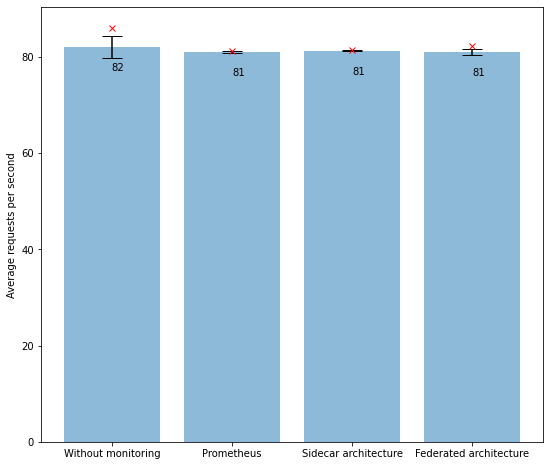

In [17]:
def barplot_2(df, mean_str, std_str, ylabel, spacing):   
    fig, ax = plt.subplots(figsize=(9,8))
    ax.bar(df.index, mean_str, yerr=std_str, alpha=0.5, data=df, capsize=10)
    for index, row in pd.DataFrame(df[mean_str]).iterrows():
        ax.text(index, row[mean_str] + spacing, round(row[mean_str]))
        
    for index, row in pd.DataFrame(df['max']).iterrows():
        ax.plot(index, row['max'], marker='x', color='r')
    plt.ylabel(ylabel)

barplot_2(load_test, 'mean', 'std', 'Average requests per second', -5)
plt.savefig('requests-per-second.png')

## Non-evaluation data analysis

The code below is not related to the evaluation, but was used to obtain a figure that illustrates the spikes in the number of transmitted bytes. 

In [18]:
at_rest_start = datetime(2022, 5, 19, 17, 25, 5)
at_rest_stop = datetime(2022, 5, 19, 17, 26, 5)
with_prometheus_monitoring_tx_bytes_at_rest_spiky = select_time_frame(with_prometheus_monitoring_tx_bytes, at_rest_start, at_rest_stop, False)


Text(0.5, 0, 'Time')

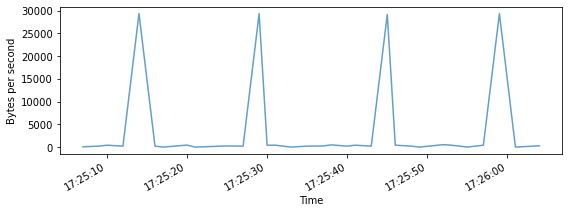

In [19]:
with_prometheus_monitoring_tx_bytes_at_rest_spiky[with_prometheus_monitoring_tx_bytes_at_rest_spiky.container_name=='k8s_POD_details-v1-994cb687f-czdps_without-monitoring_15375d17-456f-451c-8834-b79c1f153319_0'].plot('date', 'tx_bytes.mean_value', legend=False, figsize=(9,3), alpha=0.7)
plt.ylabel('Bytes per second')
plt.xlabel('Time')